In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import sys
sys.path.append('../src')
from multiclass import *

import torch 

from IPython.display import display

In [2]:
PATH = os.path.abspath('..')

# Random vs pre-trained initialization

In [3]:
train_label_csv = f'{PATH}/catalogs/train-oh_p50.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)

In [4]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=16)


In [52]:
def plot_comparison_with_marginals(y_test, p_test, label=None):
    
    gs = matplotlib.gridspec.GridSpec(20, 20)
    
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    *_, im = ax.hist2d(y_test[:, 0], p_test[:, 0], bins=100, range=[[8.2, 9.3], [8.2, 9.3]], cmap='cubehelix_r', norm=matplotlib.colors.LogNorm(vmin=1, vmax=100), alpha=1)
    ax.plot([8.2, 9.3], [8.2, 9.3], c='k', ls='--', lw=3)
    
    ax.set_xlabel('SDSS [12 + log(O/H)]', fontsize=14)
    ax.set_ylabel('Predicted [12 + log(O/H)]', fontsize=14)
    
    ax.text(8.25, 9.15, f'{label}', fontsize=16)
    
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 19:])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number', fontsize=14)
    
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.linspace(8.3, 9.2, 10)
    rmse_bins = [np.sqrt(np.mean(((p_test - y_test)[(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05)])**2)) for y in y_bins]
    num_in_bins = np.sum([(y_test[:, 0] > y - 0.05) & (y_test[:, 0] < y + 0.05) for y in y_bins], axis=1)
    rmse_error = rmse_np(p_test, y_test)
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c='C0', s=num_in_bins/30, label=f'<RMSE>={rmse_error:.4f}')

    
    ax_marg.set_ylabel('Residual\nscatter', fontsize=14)
    ax_marg.legend(fontsize=12, framealpha=0.0, frameon=False)
    ax_marg.set_ylim(0, 0.3)
    ax_marg.set_xlim(8.2, 9.3)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', c='C0')
        


In [10]:
# train-val permutation
np.random.seed(1234)
np.random.permutation(n)

# params
sz = 128
bs = 128
arch = resnet34

# Random initialization, same training routine

In [11]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data, pretrained=False)
metrics = [rmse]
learn.crit = rmse

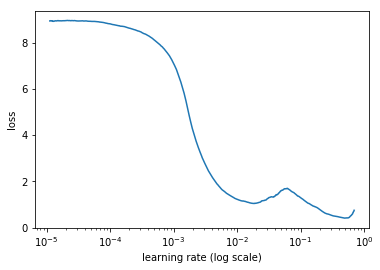

In [13]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-2, 3e-2, 1e-1]
learn.unfreeze()

learn.fit(lrs, 1)
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

epoch      trn_loss   val_loss                                 
    0      0.161104   0.161239  
    1      0.167428   0.160737                                 


epoch      trn_loss   val_loss                                 
    0      0.124432   0.123518  


epoch      trn_loss   val_loss                                  
    0      0.103024   0.094014  
  0%|          | 6/1200 [00:03<11:03,  1.80it/s, loss=0.103]

In [42]:
#learn.save('resnet34_rand-init_regular-train')
learn.load('resnet34_rand-init_regular-train')

In [43]:
Z_pred_ensemble, _ = learn.TTA(is_test=True)
Z_pred = np.mean(Z_pred_ensemble, axis=0)

In [29]:
df_test = pd.read_csv(f'{PATH}/catalogs/test-oh_p50.csv', index_col=0)
display(df_test.head())

Z_true = df_test.oh_p50.values

img_names = [np.int64(os.path.splitext(os.path.basename(img_name))[0]) for img_name in data.test_ds.fnames]
Z_true = df_test.loc[img_names].values


,oh_p50
objID,
1237648672922206684,8.676655
1237648673431879906,8.915661
1237648673458028997,8.824834
1237648673459470810,8.598277
1237648673994768731,8.486758


In [45]:
# random init
loss_ri = rmse_np(Z_pred, Z_true)
loss_ri

0.09206046552772496

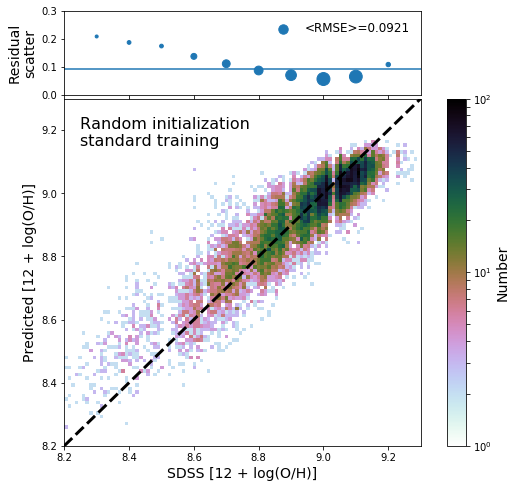

In [56]:
plot_comparison_with_marginals(Z_true, Z_pred, label='Random initialization \nstandard training')

# Random initialization, superconvergent learning

In [ ]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data, pretrained=False)
metrics = [rmse]
learn.crit = rmse

In [ ]:
learn.unfreeze()

In [ ]:
lr = 0.1            # maximum lr
lr_factor = 10      # minimum lr = lr/lr_factor
lr_anneal_pct = 15. # percentage of cycle to cosine anneal

cycle_len = 70

momentum_max = 0.95 # maximum of momentum (when at min lr)
momentum_min = 0.85 # minimum of momentum (when at max lr)
weight_decay = 1e-4 # weight decay (constant)

In [ ]:
learn.fit(lr, 1, 
          cycle_len=cycle_len, 
          use_clr_beta=(lr_factor, lr_anneal_pct, momentum_max, momentum_min), 
          wds=weight_decay)

In [65]:
#learn.save('resnet34_rand-init_superconvergent')
learn.load('resnet34_rand-init_superconvergent')

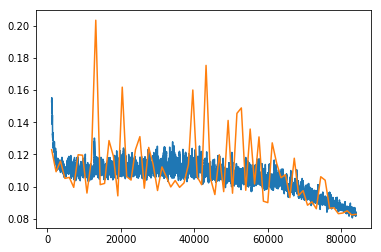

In [27]:
learn.sched.plot_loss(n_skip=1200)
plt.plot(np.arange(1, cycle_len+1)*1200, learn.sched.val_losses)

In [58]:
Z_pred_ensemble, _ = learn.TTA(is_test=True)
Z_pred = np.mean(Z_pred_ensemble, axis=0)

In [60]:
loss_sc = rmse_np(Z_pred, Z_true)
loss_sc

0.08387624913808701

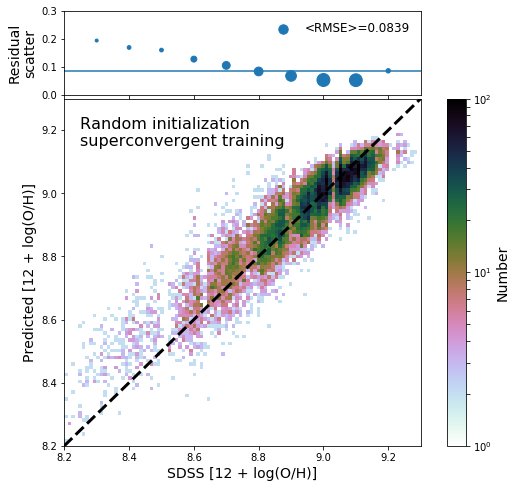

In [61]:
plot_comparison_with_marginals(Z_true, Z_pred, label='Random initialization \nsuperconvergent training')

# Continue fine-tuning superconvergent model

In [ ]:
learn.load('resnet34_rand-init_superconvergent')

epoch      trn_loss   val_loss                                  
    0      0.085839   0.083205  
    1      0.083933   0.081625                                  
    2      0.084071   0.081934                                  
    3      0.086125   0.082599                                  
    4      0.084083   0.082036                                  
    5      0.08574    0.081721                                  
    6      0.081865   0.08171                                   


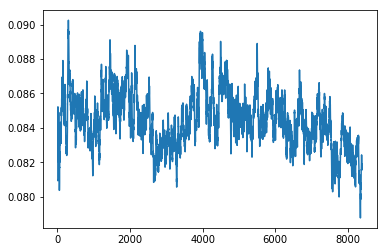

In [67]:
lrs = 1e-2 * np.array([1/100, 1/10, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [72]:
#learn.save('resnet34_rand-init_superconvergent-2')

In [69]:
Z_pred_sc2 = learn.TTA(is_test=True)[0].mean(axis=0)

loss_sc2 = rmse_np(Z_pred_sc2, Z_true)
loss_sc2

0.08266978818219373

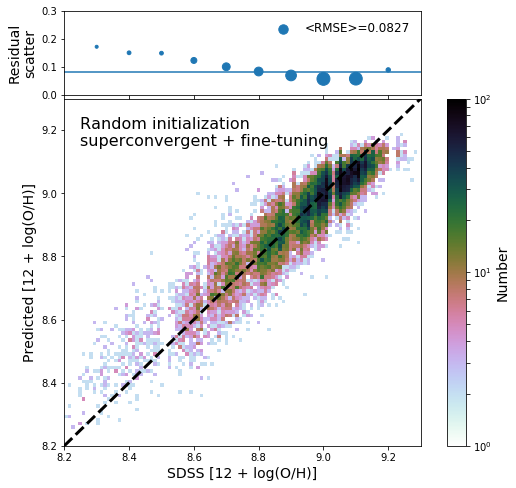

In [71]:
plot_comparison_with_marginals(Z_true, Z_pred_sc2, label='Random initialization \nsuperconvergent + fine-tuning')